#### Imports & Misc Functions

In [2]:
!pip install gym
import cv2, os, time, sys, copy
import numpy as np
import matplotlib.pyplot as plt

from gym import spaces, Env
import gym

cwd = os.path.join('..', 'forest_env')

os.chdir(cwd)
from forest import Forest

from collections import deque
from keras.models import load_model

# ml imports
import tensorflow as tf
from tensorflow import keras

tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [3]:
def run_and_plot(Agent, environment, buffer_size=1000, episodes=800, init_epsilon=0.9, gamma=0.85, batch_size=64, learning_rate=0.01, train_rate=4, tau=.5, 
                 plt_limit=None):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    agent = Agent(environment)
    if Agent != DQN:       # will be the modified version of DQN, which will need tau 
            model, epsilons, rewards = agent.train(N=buffer_size,
                                                   M=episodes,
                                                   init_epsilon=init_epsilon,
                                                   gamma=gamma,
                                                   batch_size=batch_size,
                                                   learning_rate=learning_rate,
                                                   train_rate=train_rate,
                                                   tau=tau)
    else:
        model, epsilons, rewards = agent.train(N=buffer_size,
                                                M=episodes,
                                                init_epsilon=init_epsilon,
                                                gamma=gamma,
                                                batch_size=batch_size,
                                                learning_rate=learning_rate,
                                                train_rate=train_rate)

    x = np.linspace(0, episodes, episodes)

    # rewards plot
    ax[0].set_title('Cumulative Reward Throughout Episodes', size=15)
    ax[0].set_xlabel('Episodes', fontsize=15)
    ax[0].set_ylabel('Cumulative Reward', fontsize=15)
    ax[0].tick_params(labelsize=15)
    
    if plt_limit is not None:
        ax[0].set_ylim(plt_limit)

    ax[0].plot([0, episodes], [0, 0], color='red')
    ax[0].plot(x, rewards, label='Actual')

    coeff = np.polyfit(x, rewards, 10)
    yfit = np.poly1d(coeff)(x)
    ax[0].plot(x, yfit, label='Fitted', color='orangered')
    
    ax[0].legend(fontsize=12)
    
    # epsilon plot
    ax[1].set_title('Epsilon Value Throughout Episodes', size=15)
    ax[1].set_xlabel('Episodes', fontsize=15)
    ax[1].set_ylabel('Epsilon', fontsize=15)
    ax[1].tick_params(labelsize=15)
    
    ax[1].plot(x, epsilons)
    
    plt.show()

    return agent


def evaluate(model, environment, attempts, name):
    cumulative_rewards = []
    for i in range(attempts):
        observation = environment.reset()
        cumulative_reward = 0 
        done = False
        while not done:
            action = model.step(observation)
            observation, reward, done, info = environment.step(action)
            cumulative_reward += reward
        cumulative_rewards.append(cumulative_reward)
        print('\rattempt %d, reward of %f..' % (i+1, cumulative_reward), end='')
    print('\r')
    plt.figure(figsize=(7.5,5))
    plt.title('%s Evaluation' % name, size=15)
    plt.ylabel('Reward', fontsize=15)
    plt.xlabel('Attempts', fontsize=15)
    plt.tick_params(labelsize=15)

    plt.plot(np.arange(attempts), cumulative_rewards, label='Actual')

    avg = np.sum(cumulative_rewards)/attempts
    plt.plot([0, attempts], [avg, avg], label='Average')
    plt.legend(fontsize=12)

    plt.show()
    
    return 

def load(name):
    model = load_model(os.path.join(cwd, name))
    return model

#### Forest Environment

In [4]:
# class that defines the grid environment to be used
class Forest(Env):
 
    metadata = {'renderer.modes': []}
 
    # function that defines the action and observation space
    # outputs - None
    def __init__(self):
        self.stoh = False
        # define the environment
        self.dims = (5, 5)                                                     # dimensions of the environment
        self.observation_space = spaces.Discrete(np.product(self.dims))        # define number of states
        self.action_space = spaces.Discrete(4)                                 # define number of actions
 
        # define initial states of the environment        
        self.safe_house = np.subtract(self.dims, 1)                            # goal state, the safe house! (force the safe house into the corner of the grid)
        self.init_agent = [0, 0]                                               # starting position of the agent
        self.init_energy = 25                                                  # initial energy, needed if environment needs to be reset (maximum timesteps)
        self.queue_queue = []                                                  # a queue of lines, so queue queue. get it? british joke. it's for rendering. 
        self.agent_img = 'agent_alive_up'                                      # for rendering, image of agent's last state
 
        # load images used to visualize the environment
        img_dir = os.path.join(cwd, 'images')
        self.images = {}
        fns = [i for i in os.listdir(img_dir) if i.endswith('.png')]
        for c, fn in enumerate(fns):
            image = cv2.imread(os.path.join(img_dir, fn), 1)
            self.images[fn.split('.')[0]] = image
            print('\rloading images.. %d/%d' % (c+1, len(fns)), end='')
        print('\rloading images.. DONE.')
    
        # define points of interest within the forest
        init_picnic_basket = POI(impact=.1,                                     # picnic basket -> GOOD. someone left a picnic basket behind with a lot of food. YAY.
                                 locations=set([(4,0), (4,3)]),
                                 img_avail='picnic_avail')
        init_berries = POI(impact=.05,                                          # berries       -> wildberries, should be good. GOOD.
                           locations=set([(2,1), (3,2), (3,4)]), 
                           img_avail='berries_avail')                                     
        init_deer_poop = POI(impact=-.05,                                       # deer poop     -> BAD. looks like berries, NOT BERRIES. NOT GOOD. 
                             locations=set([(1,2), (0,3)]), 
                             img_avail='deer_poop_avail')      
        init_twig = POI(impact=.05,                                             # twigs         -> BAD. it's dark. he tripped. PAIN. 
                        locations=set([(1,4), (2,3), (4,1)]),
                        img_avail='twig')
        init_trees = POI(impact=-.1,                                            # trees         -> BAD. don't run into trees. not good. 
                         locations=set([(1,3), (3,0)]), 
                         img_avail='tree')                                       
        init_bear_trap = POI(impact=-1,                                         # bear trap     -> BAD. if a bear can't handle it, you can't either. YOU'RE DEAD. 
                             locations=set([(3,3)]), 
                             img_avail='bear_trap')                                  
        safe_house = POI(impact=1,
                         locations=set([tuple(self.safe_house)]),
                         img_avail='house')
 
        # dictionary of points of interest, to make things a little easier on the code
        self.POIs = {'picnic': init_picnic_basket,
                     'berries': init_berries,
                     'deer_poop': init_deer_poop,
                     'twig': init_twig, 
                     'trees': init_trees,
                     'trap': init_bear_trap,
                     'house': safe_house}
        
        # create the environment             
        self.init_background = self.images['background']
        
        self.init_state = np.zeros(self.dims)                                             # define the environment state
        for i, name in enumerate(self.POIs):                                              # for each point of interest, 
            poi = self.POIs[name]                                                             # get the POI
            for loc in poi.locations:                                                         # for each location where POI is located, 
                self.init_state[tuple(loc)] = poi.impact                                          # set the impact of the POI
                image = poi.img_avail
                self.init_background = self.__draw_poi__(image, loc, self.init_background)        # update the visualization image
 
                print('\rdrawing initial environment.. %d/%d' % (i+1, len(self.POIs)), end='')
        print('\rdrawing initial environment.. DONE.')
 
        #self.init_state = np.sign(self.init_state)
 
 
    # function that resets the state of the environment to the initial state
    # inputs - None
    # outputs - the initial observation state
    def reset(self):
        self.energy = copy.deepcopy(self.init_energy)
        self.agent = copy.deepcopy(self.init_agent)
        self.state = copy.deepcopy(self.init_state)
 
        self.background = copy.deepcopy(self.init_background)
        self.background_n_agent = copy.deepcopy(self.background)
        self.queue_queue = []
        self.agent_img = 'agent_alive_down'
        
        observation = self.to_state(self.agent)
        
        ret = np.zeros(self.observation_space.n)
        ret[observation - 1] = 1
        return ret
 
 
    # function that executes one timestep within the environment
    # inputs - action - the action to be taken in this timestep
    # outputs - observation - the new state after an action is taken 
    #         - reward - float, the updated reward
    #         - done - True if reached the goal state, False otherwise
    #         - info - additional infomation (nothing for now)
    def step(self, action):  
        start_pos = np.array(self.agent) # save the current position for line drawing
 
        # update the position of the agent based on the action 
        self.agent, agent_img = self.__calculate_direction__(action)
 
        self.energy -= 1
 
        observation = self.to_state(self.agent)
 
        # check if agent is done
        if (self.agent == self.safe_house).all(): # agent reached safe house
            done = True
        elif self.energy <= 0: # agent ran out of energy
            agent_img = 'agent_no_energy'
            done = True
        else:
            done = False
 
        # for rendering
        self.queue_queue.append((start_pos, np.array(self.agent)))
        self.agent_img = agent_img
 
        reward = self.state[tuple(self.agent)]
        
        self.state[tuple(self.agent)] = min([reward, 0]) if reward > 0 else max([reward, 0])
        
        info = {}

        ret = np.zeros(self.observation_space.n)
        ret[observation - 1] = 1

        return ret, reward, done, info
 
 
    # function that, given an action, returns the next state and the probability of that state
    # inputs - loc - optional, location to explore. if not defined, will be set to agent's current position
    # outputs - dictionary key-value pair of (action -> (state, probability))
    def explore(self, loc=None):
        if loc is None:
            loc = self.agent
 
        ret = {}
        x, y = loc
        actions = [[x, y - 1],   # up
                   [x - 1, y],   # left
                   [x, y + 1],   # down
                   [x + 1, y]]   # right
 
        for i, _ in enumerate(actions):
            actions[i] = np.clip(actions[i], 0, self.dims[0] - 1)
            actions[i] = self.to_state(actions[i])
        
        for i, act in enumerate(actions):
            if not self.stoh:
                ret[i] = [(self.to_state(act), 1)] # (reward, probability of reward)
            else:
                ret[i] = [(self.to_state(act), .5)]
 
                if i % 2 == 0:
                    others = [(actions[1], .25),
                              (actions[3], .25)]
                else:
                    others = [(actions[0], .25),
                              (actions[2], .25)]
                ret[i].extend(others)
        return ret
 
 
    # function that converts coordinate on the grid to a state number
    # inputs - (x, y), coordinate location
    # outputs - int, state number
    def to_state(self, coord):
        x, y = coord
        return int((self.dims[1]) * y + x)
 
 
    # function that converts state number to coordinate i ngrid
    # inputs - int, state number
    # outputs - [x, y], coordinate location 
    def to_coord(self, state_num):
        return [int(state_num % self.dims[0]), int(state_num // self.dims[1])]
 
 
    # function that visualizes the environment
    # inputs - None
    # outputs - None, but shows the environment
    def render(self):
        # draw the lines representing the agent's path
        while self.queue_queue:
            p, q = self.queue_queue.pop(0)
            self.__draw_line__(p, q, self.background)
            
        self.__draw_agent__(self.agent_img)
        plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
        plt.axis('off')
 
        plt.imshow(cv2.cvtColor(self.background_n_agent, cv2.COLOR_BGR2RGB))
        return self.background_n_agent
 
 
    def set_stoh(self, stohchastic=False):
        self.stoh = stohchastic
        return 
 
 
    # helper function for step(), calculates the new direction
    # inputs - action - action from Agent
    # outputs - agent - the agent position to be updated
    #         - agent_img - image that is needed for rendering 
    def __calculate_direction__(self, action):
        if self.stoh:
            roll = np.random.uniform()
            if action % 2 == 0: # moving up/down
                if roll < .25:
                    action = 1
                elif roll < .5:
                    action = 3
                
            else: # moving left/right
                if roll <.25:
                    action = 0
                elif roll < .5:
                    action = 2
 
        agent_img = None
        agent = self.agent
        # even moving vertically, odd moving horizontally 
        if action == 0:
            agent[1] -= 1
            agent_img = 'agent_alive_up'   
        elif action == 2:
            agent[1] += 1
            agent_img = 'agent_alive_down'
        elif action == 1:
            agent[0] -= 1
            agent_img = 'agent_alive_left'
        elif action == 3:
            agent[0] += 1
            agent_img = 'agent_alive_right'
        
        agent = np.clip(agent, 0, self.dims[0] - 1)
        return agent, agent_img
    
    
    # helper function for step(), updates the environment by drawing the agent's new location
    # inputs - agent_img - image to be drawn
    # outputs - None
    def __draw_agent__(self, agent_img):  
        temp = np.copy(self.background)
        temp = self.__draw_poi__(agent_img, self.agent, temp)
        self.background_n_agent = temp
        return 
    
    
    # helper function for step(), draws a line onto an image
    # inputs - pc - tuple(x, y), starting point of the line
    #        - qc - tuple(x, y), ending point of the line
    #        - image - image that the line is to be drawn on
    # outputs - image with line drawn in specified coordinates
    def __draw_line__(self, pc, qc, image):
        width, height = np.divide(image.shape[:2], self.dims)
        mpw, mph = width/2, height/2
        sp = (int(pc[0] * width + mpw), int(pc[1] * height + mph))
        ep = (int(qc[0] * width + mpw), int(qc[1] * height + mph))
        
        cv2.arrowedLine(image, sp, ep, color=(0, 255, 0), thickness=5)
        return image
    
 
    # helper function for step(), draws an image onto another image (aka POI onto background)
    # inputs - image - string, name of the image that is to be drawn
    #        - coords - (x, y), coordinates where the image is to be drawn 
    #        - background - image, background environment
    # outputs - the updated background (inluding image at the given coordinate)
    def __draw_poi__(self, name, coords, background):
        image = self.images[name]
        width, height = [int(a) for a in np.divide(background.shape[:2], self.dims)]
        for w in range(width):
            for h in range(height):
                i = coords[0] * width + w
                j = coords[1] * height + h
                if (image[h][w] != [255, 255, 255]).all():
                    background[j][i] = image[h][w]
        return background
 
 
class POI:
    # class that defines a point of interest (aka rewards, negative and positive) within the environment
 
    # function that initializes a POI class
    # inputs - impact - integer, the impact it will have on the agent, can be a negative or positive impact
    #        - locations - set of [x, y], locations of the POIs
    #        - img_avail - string, name of the image when the object is available 
    
    # outputs - None
    def __init__(self, impact=0, locations=[], img_avail=None):
        self.impact = impact
        self.locations = locations
        self.img_avail = img_avail

#### DQN Helper Classes (Experience, Memory)

In [5]:
class Experience():
    # function that initializes an Experience to be stored in memory
    # inputs - state - the current state of the agent
    #        - action - the action that was taken
    #        - reward - the reward for taking action from state
    #        - next_state - the resulting state for taking action 
    #        - done - boolean value, whether or not next_state is the terminal state
    # outputs - None
    def __init__(self, state, action, reward, next_state, done):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state
        self.done = done
        return
 
 
    # function that turns the Experience object into a tuple of values
    # inputs - None
    # outputs - SARS in the form of a tuple
    def to_tuple(self):
        return (self.state, self.action, self.reward, self.next_state, self.done)

In [6]:
class Memory():
    # function that initializes the replay memory
    # inputs - N - size of the memory 
    # outputs - None
    def __init__(self, N):
        self.arr = False

        self.N = N
        if self.arr:
            self.mem = []
        else:
            self.mem = deque()
        return 
 
 
    # function that stores Experience, exp, in memory.
    # inputs - exp - Experience object, to be store into the memory
    def store(self, exp):
        if len(self.mem) < self.N:                   # if memory is not full yet, 
            self.mem.append(exp)                         # add memory to experiences
        else:                                        # otherwise, 
            #tbr = np.random.choice(self.N)               # pick a random memory to remove
            #self.mem[tbr] = exp                          # exchange memory for new memory
            if self.arr:
                self.mem.pop(0)
            else:
                self.mem.popleft()
            self.mem.append(exp)
        return self.mem
 
 
    # pick a random minibatch of transistions from D 
    # inputs - size - size of the minibatch
    # outputs - list of Experiences of size 'size'
    def sample(self, size):
        if self.arr:
            return np.random.choice(self.mem, size=size)
        else:
            samp = np.random.randint(len(self.mem), size=size)
            return [self.mem[i] for i in samp]
    
    def size(self):
        return len(self.mem)

#### Vanilla DQN

In [7]:
class DQN():
    # function that initializes a DQN Agent 
    # inputs - env - Environment that agent is to be acting upon
    # outputs - None
    def __init__(self, env=None):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space  
        return
    
    # function that creates a model that is used to predict the optimal action
    # inputs - learning_rate - rate at which the NN learns
    # outputs - model 
    def __create_model__(self, learning_rate):
        model = keras.models.Sequential()   
        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dense(self.env.action_space.n))
        model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate), 
                           loss=tf.keras.losses.MeanSquaredError())
        return model

    
    # function that picks a proceeding action based on epsilon-greedy
    # inputs - state - current state of the agent 
    #        - eps - episilon value, picks random if below eps, greedy if above.
    # outputs - an action 
    def __eps_greedy__(self, state, eps):
        if np.random.uniform() < eps:
            action = np.random.choice(self.action_space.n)
        else:
            pred = self.policy.predict(state.reshape(1, np.prod(state.shape)))[0]
            action = np.random.choice(np.where(pred == np.max(pred))[0], 1)[0]
        return action
 

    # inputs - N - integer, maximum length of replay memory
    #        - M - integer, number of episodes to perform 
    #        - init_epsilon - epsilon value, for epsilon decay
    #        - gamma - discount factor
    #        - batch_size - size of minibatches to be trained
    #        - learning_rate - the rate at which the NN learns
    #        - train_rate - how frequent the model is trained
    # output - self.policy - the optimal policy
    #        - epsilons - an array of M epsilon values (for plotting)
    #        - cumu_rewards - an array of M cumulative reward values (for plotting)
    def train(self, N=1000, M=500, init_epsilon=0.9, gamma=0.85, batch_size=64, learning_rate=0.005, train_rate=4):
        epsilons = []                                                                      # keep track of epsilon values for plotting
        cumu_rewards = []                                                                  # keep track of cumulative rewards for plotting
        epsilon = init_epsilon
        
        mem = Memory(N)                                                                    # initialize replay memory
        self.policy = self.__create_model__(learning_rate)                                 # initialize action-val function, Q
        timestep = 0
        for episode in range(M):                                                           # for each episode, 
            start = time.time()
            cumulative_reward = 0                                                              # keep track of the cumulative reward
            next_state = self.env.reset()                                                      # reset the environment
            done = False
            while not done:                                                                    # while not reached maximum number of timesteps, 
                state = next_state                                                                 # save current state
                action = self.__eps_greedy__(state, epsilon)                                       # select action w/ epsilon greedy
                next_state, reward, done, info = self.env.step(action)                             # take action in environment, get next state
                cumulative_reward += reward                                                        # update cumulative reward value
                
                mem.store(Experience(state, action, reward, next_state, done))                     # store experience in memory

                if timestep % train_rate == 0 and mem.size() > batch_size:                         # train network every X timesteps (defined in parameters)
                    batch = mem.sample(batch_size)                                                     # grab a bundle of experiences
            
                    X = np.array([exp.state for exp in batch])                                         # grab the current states for the experiences
                    y = self.policy.predict(X)                                                         # predict next action given current policy
                    y_next = self.policy.predict(np.array([exp.next_state for exp in batch]))          # optimal action from the next state based on the target policy
    
                    for i, exp in enumerate(batch):                                                    # for each experience in sampled batch, 
                        q = exp.reward if exp.done else exp.reward + gamma * np.max(y_next[i])             # updated q-value
                        y[i][exp.action] = q                                                               # update the expected q-value for the given action 
                    
                    self.policy.fit(X, y, epochs=1, verbose=0)                                         # fit the model with X, y

                timestep += 1                                                                      # update timestep count (for when to train network)
            
            epsilon = init_epsilon * np.exp(-episode/(M/3)) if epsilon > .1 else .1                # decay epsilon value 
            #epsilon = init_epsilon * np.exp(-episode/(M/3))
            
            epsilons.append(epsilon)
            cumu_rewards.append(cumulative_reward)
            print('\repisode %3d | epsilon: %1.4f | reward: %4.2f | %2.4f seconds per episode' % (episode+1, epsilon, cumulative_reward, time.time() - start), end='')
            
        return self.policy, epsilons, cumu_rewards
 
    
    # function takes a step with the current policy
    # inputs - observation - current position of the agent
    # outputs - action - action that is to be taken based on the current policy
    def step(self, observation):
        actions = self.policy.predict(observation.reshape(1, len(observation)))[0]
        action = np.argmax(actions)
        return action

    def save(self, name):
        self.policy.save(os.path.join(cwd, name))
        return self.policy

#### Vanilla DQN Results

##### Vanilla DQN Results (Forest)

In [8]:
forest = Forest()

loading images.. DONE.
drawing initial environment.. DONE.


C:\Users\Mark\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


episode 250 | epsilon: 0.1000 | reward: 1.15 | 0.0487 seconds per episodee

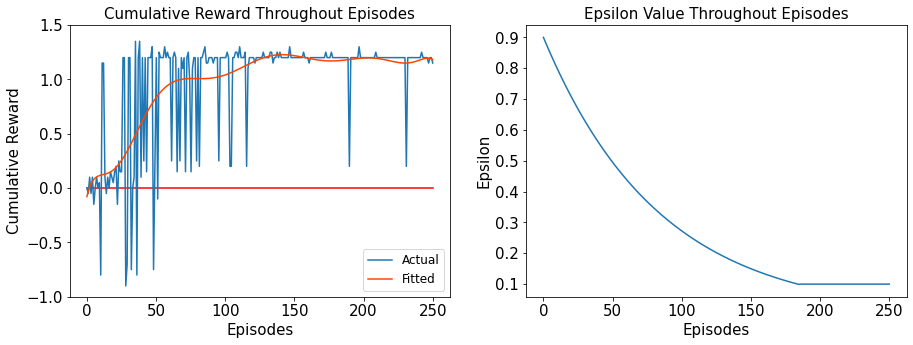

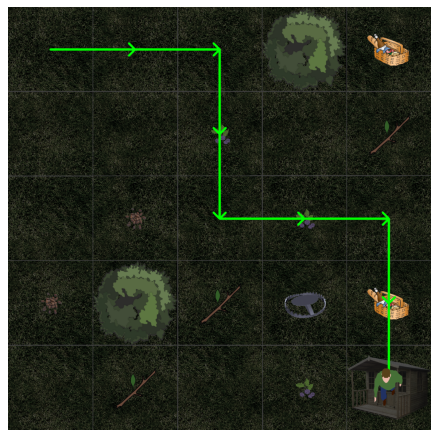

In [11]:
tf.compat.v1.disable_eager_execution()

dqn = run_and_plot(DQN,
                   forest,
                   buffer_size=1000, 
                   episodes=250, 
                   init_epsilon=0.9,
                   gamma=0.8, 
                   batch_size=64, 
                   learning_rate=0.001, 
                   train_rate=4,
                   plt_limit=[-1, 1.5])

observation = forest.reset()
done = False
while not done:
    action = dqn.step(observation)
    observation, reward, done, info = forest.step(action)

forest.render();

attempt 5, reward of 1.200000..


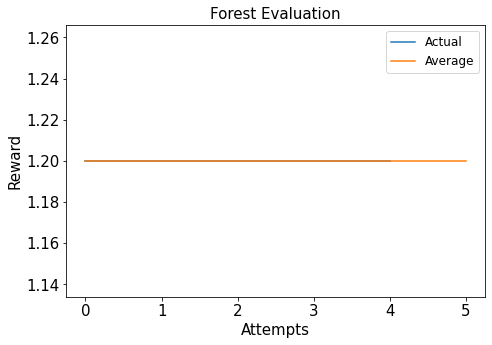

In [13]:
evaluate(dqn, forest, 5, 'Forest')

##### Vanilla DQN Results (CartPole-v1)

episode   3 | epsilon: 0.9881 | reward: 10.00 | 0.0000 seconds per episode

C:\Users\Mark\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


episode 500 | epsilon: 0.1000 | reward: 254.00 | 1.9019 seconds per episode

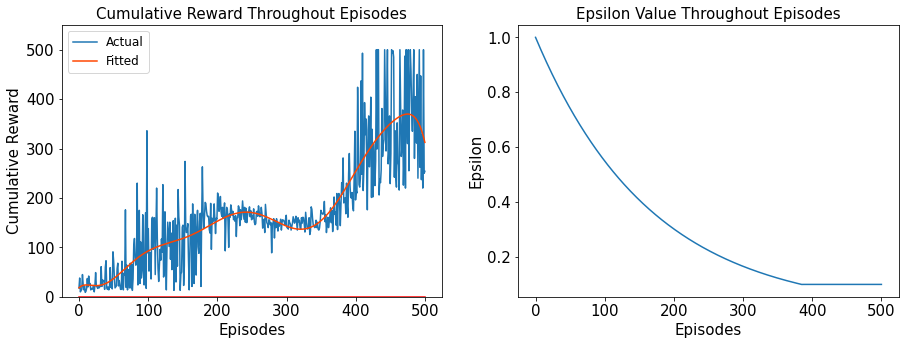

In [32]:
tf.compat.v1.disable_eager_execution()

cartpole = gym.make('CartPole-v1')
cartpole_vanilla_dqn = run_and_plot(DQN,
                                  cartpole,
                                  buffer_size=5000, 
                                  episodes=500, 
                                  init_epsilon=1,
                                  gamma=.95, 
                                  batch_size=64, 
                                  learning_rate=0.001, 
                                  train_rate=3,
                                  plt_limit=[0, 550])
 
cartpole_vanilla_dqn.save('../models/cartpole_vanilla_dqn.h5');

attempt 100, reward of 500.000000..


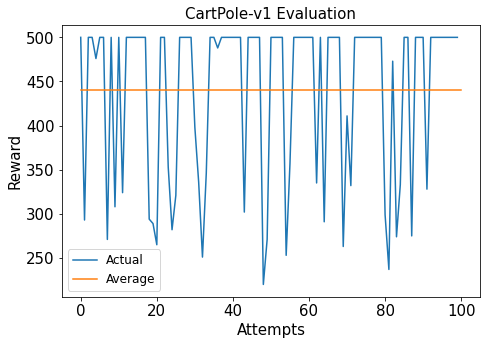

In [33]:
evaluate(cartpole_vanilla_dqn, cartpole, 100, 'CartPole-v1')

##### Vanilla DQN Results (Acrobot-v1)

C:\Users\Mark\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


episode 500 | epsilon: 0.1000 | reward: -168.00 | 0.8847 seconds per episode

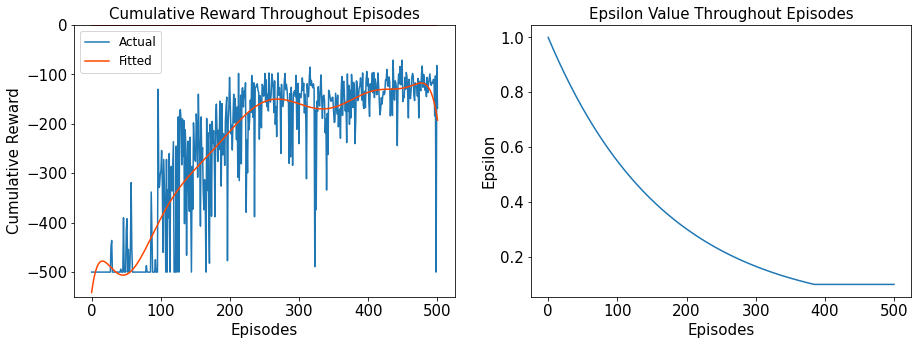

In [36]:
tf.compat.v1.disable_eager_execution()
acrobot = gym.make('Acrobot-v1')
acrobot_vanilla_dqn = run_and_plot(DQN,
                                    acrobot,
                                    buffer_size=5000, 
                                    episodes=500, 
                                    init_epsilon=1,
                                    gamma=.95, 
                                    batch_size=64, 
                                    learning_rate=0.0001, 
                                    train_rate=5,
                                    plt_limit=[-550, 0])
acrobot_vanilla_dqn.save('../models/acrobot_vanilla_dqn.h5')

attempt 100, reward of -100.000000..


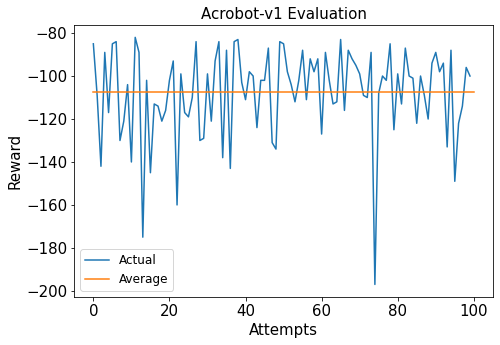

In [37]:
evaluate(acrobot_vanilla_dqn, acrobot, 100, 'Acrobot-v1')

#### Chocolate DQN (Not really chocolate, but modified - Double DQN)

In [15]:
# modified version of the DQN, specifically, changing it so it implements Double DQN.
# functions from parent class, DQN:
#    - __init__()
#    - __create_model__()
#    - __eps_greedy__()
#    - __step__()
# 
# for the function details, refer to the class above (DQN).
class mod_DQN(DQN):
    # inputs - N - integer, maximum length of replay memory
    #        - M - integer, number of episodes to perform 
    #        - init_epsilon - epsilon value, for epsilon decay
    #        - gamma - discount factor
    #        - batch_size - size of minibatches to be trained
    #        - learning_rate - the rate at which the NN learns
    #        - train_rate - how frequent the model is trained
    # output - self.policy - the optimal policy
    #        - epsilons - an array of M epsilon values (for plotting)
    #        - cumu_rewards - an array of M cumulative reward values (for plotting)
    def train(self, N=1000, M=500, init_epsilon=0.9, gamma=0.85, batch_size=64, learning_rate=0.005, train_rate=4, tau=0.01):
        epsilons = []                                                                      # keep track of epsilon values for plotting
        cumu_rewards = []                                                                  # keep track of cumulative rewards for plotting
        epsilon = init_epsilon
        
        mem = Memory(N)                                                                    # initialize replay memory
        self.policy = self.__create_model__(learning_rate)                                 # initialize action-val function, Q
        self.target = self.__create_model__(learning_rate)                                 # create target network 

        timestep = 0                                                                       # keep track of timesteps for training
        for episode in range(M):                                                           # for each episode, 
            start = time.time()
            cumulative_reward = 0                                                              # keep track of the cumulative reward
            next_state = self.env.reset()                                                      # reset the environment
            done = False
            while not done:                                                                    # while not reached maximum number of timesteps, 
                state = next_state                                                                 # save current state
                action = self.__eps_greedy__(state, epsilon)                                       # select action w/ epsilon greedy
                next_state, reward, done, info = self.env.step(action)                             # take action in environment, get next state
                cumulative_reward += reward                                                        # update cumulative reward value
                
                mem.store(Experience(state, action, reward, next_state, done))                     # store experience in memory

                if timestep % train_rate == 0 and mem.size() > batch_size:                         # train network every X timesteps (defined in parameters)
                    batch = mem.sample(batch_size)                                                     # grab a bundle of experiences
            
                    X = np.array([exp.state for exp in batch])                                         # grab the current states for the experiences
                    y = self.policy.predict(X)

                    q_policy = self.policy.predict(np.array([exp.next_state for exp in batch]))        # grab q-table for next state given the primary policy
                    q_target = self.target.predict(np.array([exp.next_state for exp in batch]))        # grab the q_table for next state given TARGET policy

                    for i, exp in enumerate(batch):
                        y[i][exp.action] = exp.reward if exp.done else exp.reward + gamma * q_policy[i][np.argmax(q_target[i])]
                        
                    self.policy.fit(X, y, epochs=1, verbose=0)                                        # fit the model with X, y
                    
                    policy_weights = np.multiply(tau, np.array(self.policy.get_weights(), dtype=object))
                    target_weights = np.multiply(1 - tau, np.array(self.target.get_weights(), dtype=object))
                    self.target.set_weights(policy_weights + target_weights)

                timestep += 1                                                                      # update timestep count (for when to train network)
            
            epsilon = init_epsilon * np.exp(-episode/(M/3)) if epsilon > .1 else .1                # decay epsilon value 
            
            epsilons.append(epsilon)
            cumu_rewards.append(cumulative_reward)
            print('\repisode %3d | epsilon: %1.4f | reward: %4.2f | %2.4f seconds per episode' % (episode+1, epsilon, cumulative_reward, time.time() - start), end='')
            
        return self.policy, epsilons, cumu_rewards

#### Chocolate DQN Results

##### Chocolate DQN Results (Forest)

In [16]:
forest = Forest()

loading images.. DONE.
drawing initial environment.. DONE.


episode 250 | epsilon: 0.1000 | reward: 1.20 | 0.1123 seconds per episodee

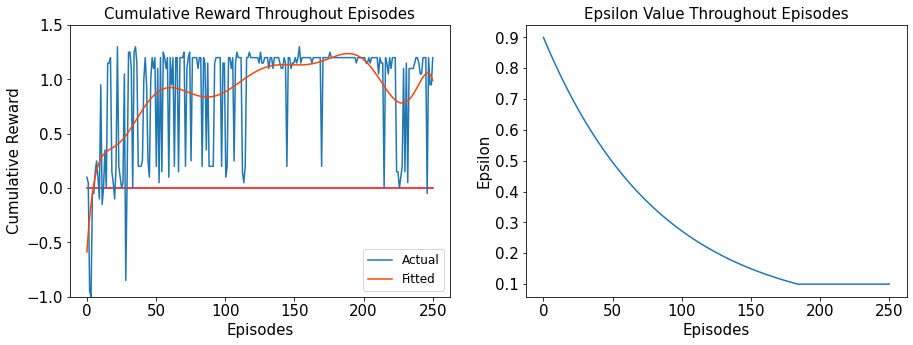

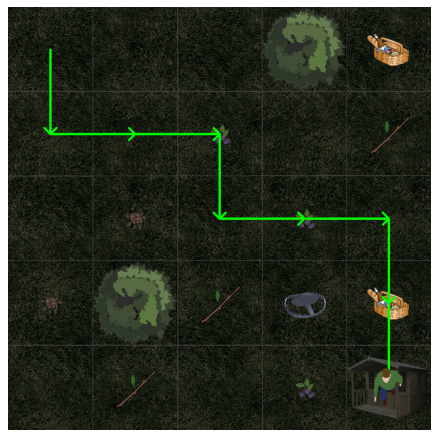

In [18]:
dqn = run_and_plot(mod_DQN,
                   forest,
                   buffer_size=1000, 
                   episodes=250, 
                   init_epsilon=0.9,
                   gamma=0.8, 
                   batch_size=64, 
                   learning_rate=0.001, 
                   train_rate=4,
                   tau=0.01,
                   plt_limit=[-1, 1.5])

observation = forest.reset()
done = False
while not done:
    action = dqn.step(observation)
    observation, reward, done, info = forest.step(action)

forest.render();

attempt 5, reward of 1.200000..


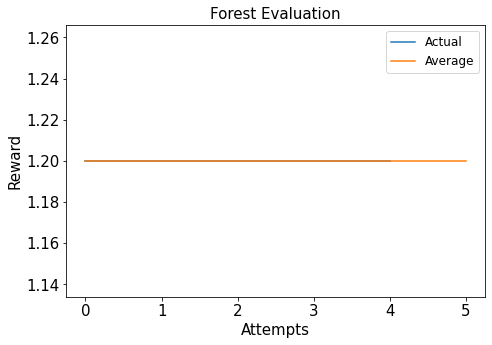

In [19]:
evaluate(dqn, forest, 5, 'Forest')

##### Chocolate DQN Results (CartPole-v1)

episode   2 | epsilon: 0.9940 | reward: 12.00 | 0.0010 seconds per episode

C:\Users\Mark\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


episode 500 | epsilon: 0.1000 | reward: 500.00 | 5.3191 seconds per episode

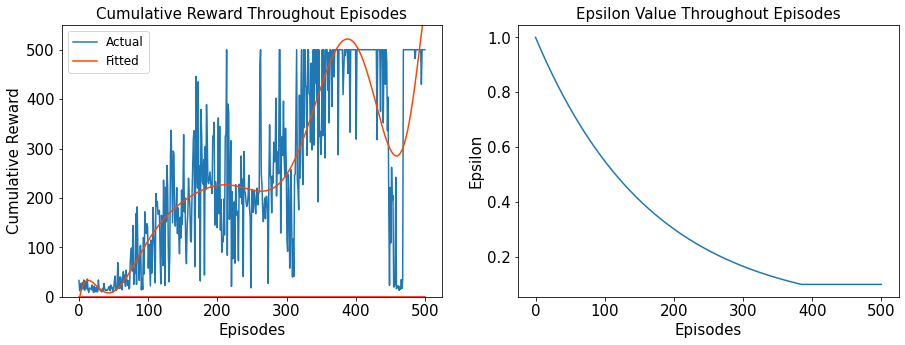

In [28]:
tf.compat.v1.disable_eager_execution()
cartpole = gym.make('CartPole-v1')
cartpole_choco_dqn = run_and_plot(mod_DQN,
                                  cartpole,
                                  buffer_size=5000, 
                                  episodes=500, 
                                  init_epsilon=1,
                                  gamma=.95, 
                                  batch_size=64, 
                                  learning_rate=0.001, 
                                  train_rate=3,
                                  tau=0.01,
                                  plt_limit=[0, 550])
 
cartpole_choco_dqn.save('../models/cartpole_choco_dqn.h5')

attempt 100, reward of 500.000000..


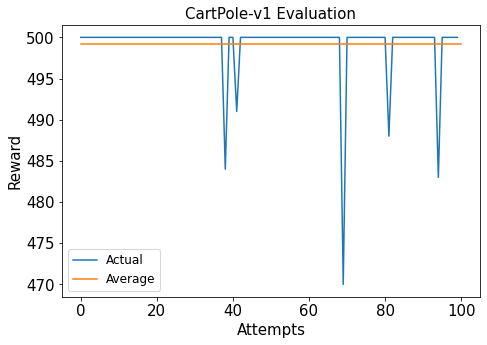

In [29]:
evaluate(cartpole_choco_dqn, cartpole, 100, 'CartPole-v1')

##### Chocolate DQN Results (Acrobot-v1)

C:\Users\Mark\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


episode 500 | epsilon: 0.1000 | reward: -110.00 | 0.6036 seconds per episode

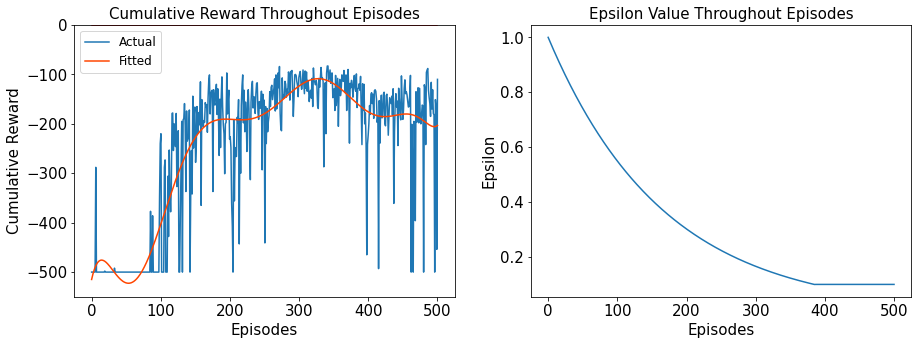

In [34]:
acrobot = gym.make('Acrobot-v1')
acrobot_choco_dqn = run_and_plot(mod_DQN,
                                    acrobot,
                                    buffer_size=2500, 
                                    episodes=500, 
                                    init_epsilon=1,
                                    gamma=.95, 
                                    batch_size=64, 
                                    learning_rate=0.0001, 
                                    train_rate=5,
                                    tau=0.01,
                                    plt_limit=[-550, 0])

acrobot_choco_dqn.save('../models/acrobot_choco_dqn.h5')

attempt 100, reward of -122.000000..


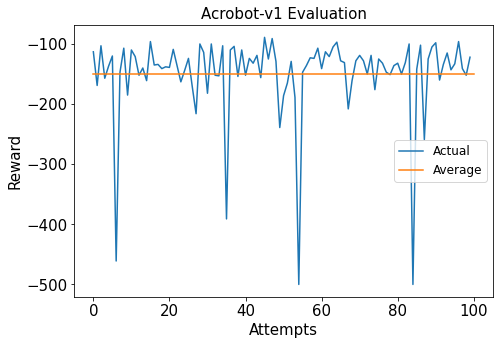

In [35]:
evaluate(acrobot_choco_dqn, acrobot, 100, 'Acrobot-v1')